In [1]:
# load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from setup_problem import load_problem
from sklearn.linear_model import Ridge # sklearn ridge regression
from ridge_regression import do_grid_search_ridge, RidgeRegression, compare_parameter_vectors, plot_prediction_functions
from random import shuffle

In [2]:
# load data
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)
print(x_train.shape)
print(y_train.shape)

(100,)
(100,)


In [3]:
# featurize data
X_train = featurize(x_train)
X_val = featurize(x_val)

#np.sum(X_train,axis=0) == 0
X_train = X_train[:,0:-5]
X_val = X_val[:,0:-5]

SECTION 2.1

In [245]:
# fit with sklearn -- need to multiply l2_reg by sample size, since their
# objective function has the total square loss, rather than average square
# loss.
l2_reg = 1
n = X_train.shape[0]
sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
sklearn_ridge.fit(X_train, y_train)
sklearn_ridge_coefs = sklearn_ridge.coef_
print(sklearn_ridge_coefs.shape)

(395,)


In [246]:
# Do hyperparameter tuning with our ridge regression
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
print(results)

    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


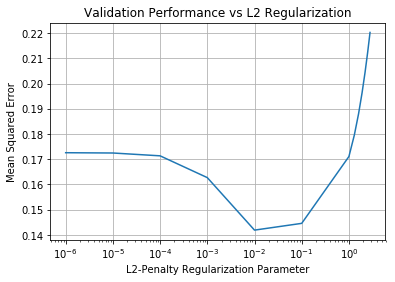

In [247]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()

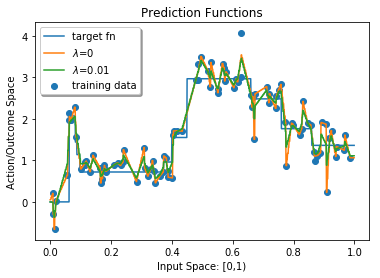

In [7]:
# SECTION 2.2
# plot the following: the training data, the target function, an unregularized
#least squares fit (still using the featurized data), and the prediction
#function chosen in the previous problem. 

pred_fns = []
xx = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

# target function
pred_fns.append({"name":"target fn", "coefs":coefs_true, "preds": target_fn(xx) })

# unregularized least squares fit (still using featurized data),  prediction function chosen in previous problem
l2regs = [0, .01]
X = featurize(xx)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "$\lambda$="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })


f = plot_prediction_functions(xx, pred_fns, x_train, y_train, legend_loc="best")
f.show()

In [224]:
def plot_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    
    for i in range(len(pred_fns)):
        
        num_ftrs = len(pred_fns[i]["coefs"])
        if (i == 0): 
            title = "Parameter values"
        else:
            title = ' '
            
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        if (i == (len(pred_fns)-1)): 
            axs[i].set_xlabel('feature index')
        else:
            axs[i].set_xlabel(' ')
        axs[i].set_ylabel(pred_fns[i]["name"])
        axs[i].set_title(title)
        
        axs[i].set_ylim([-1,1])
        #axs[i].set_ylim([min(coef_vals), max(coef_vals)])
        
    fig.subplots_adjust(hspace=0.4)
    return fig

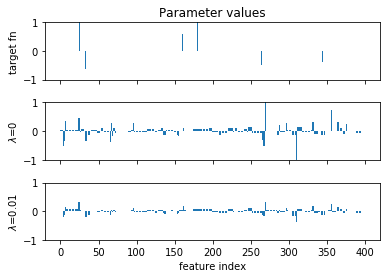

In [9]:
# Next, along the lines of the bar charts produced by the code in
#compare_parameter_vectors, visualize the coefficients for each of the prediction 
#functions plotted,including the target function. Describe the patterns, including
#the scale of the coefficients, as well as which coefficients have the
#most weight.

f = plot_parameter_vectors(pred_fns)
f.show()

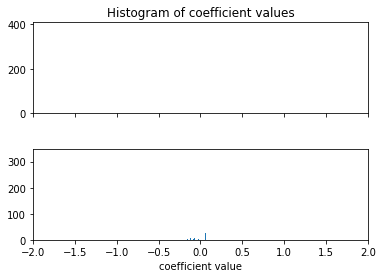

In [221]:
minn = -2
maxx = 2
binwidth = .01
fig, axs = plt.subplots(len(pred_fns),1, sharex=True)

for i in range(len(pred_fns)):
    num_ftrs = len(pred_fns[i]["coefs"])
    
    if i == 0:
        title = 'Histogram of coefficient values'
    else:
        title = ' '
    
    coef_vals = pred_fns[i]["coefs"]
    axs[i].hist(coef_vals,bins=np.arange(minn, maxx + binwidth, binwidth))
    axs[i].set_title(title)

    if (i == (len(pred_fns)-1)): 
        axs[i].set_xlabel('coefficient value')
    else:
        axs[i].set_xlabel(' ')
        
    axs[i].set_xlim([minn,maxx])
    #axs[i].set_ylim([0, 50])

fig.subplots_adjust(hspace=0.4)
fig.show()

In [11]:
# 2.3 
# 6 3 1

epsilon_vec = [1e-6, 1e-5, 1e-4, 1e-3, .005,1e-2, .05, 1e-1]
#epsilon_vec = [1e-6, 1e-3, 1e-1]
n_epsilon = len(epsilon_vec)
n_coeffs = len(pred_fns[0]["coefs"])

conf_mat = np.empty((4,n_epsilon))

idx_mat = [[0,0], [0,1], [1,0], [1,1]];

for i_epsilon in range(n_epsilon):
    epsilon = epsilon_vec[i_epsilon]
    
    true_yes = pred_fns[0]["coefs"] < epsilon
    fun_yes = pred_fns[2]["coefs"] < epsilon
    
    temp_conf_mat = sklearn.metrics.confusion_matrix(true_yes,fun_yes)
    
    conf_mat[0,i_epsilon] = temp_conf_mat[1,1] # true neg: say it is 0 and it is 0
    conf_mat[1,i_epsilon] = temp_conf_mat[1,0]
    conf_mat[2,i_epsilon] = temp_conf_mat[0,1]
    conf_mat[3,i_epsilon] = temp_conf_mat[0,0]
    
    
    

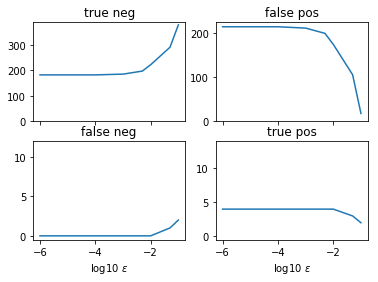

In [12]:
# plot confusion matrix figure

fig, axs = plt.subplots(2,2, sharex=True)

title_array = ['true neg', 'false pos','false neg','true pos']

for i_plot in range(4):
    
    axs[idx_mat[i_plot][0],idx_mat[i_plot][1]].plot(np.log10(epsilon_vec),conf_mat[i_plot])
    axs[idx_mat[i_plot][0],idx_mat[i_plot][1]].set_title(title_array[i_plot])
    axs[idx_mat[i_plot][0],idx_mat[i_plot][1]].set_ylim([-.5 ,max(conf_mat[i_plot]+10)])
    if idx_mat[i_plot][0] == 1:
        axs[idx_mat[i_plot][0],idx_mat[i_plot][1]].set_xlabel('log10 $\epsilon$')
    
fig.show()
    

In [50]:
np.dot(np.transpose(X_train),X_train)

array([[100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.],
       [100., 100., 100., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [4]:
def calc_loss(X,y,w,lambdaa=0):

    resid = np.dot(X,w) - y
    loss = (np.dot(np.transpose(resid),resid) + lambdaa*sum(abs(w))) #/ len(y)
        
    return loss

In [10]:
def shooting_algorithm(X, y, lambdaa, w = 'zeros', shuffle_order = False):
    
    n_features = X.shape[1]
    
    if w == 'zeros':
        w = np.zeros(n_features)
    elif w == 'ridge':
        w = np.dot(np.linalg.inv(np.dot(np.transpose(X),X) + lambdaa*np.identity(n_features)), np.dot(np.transpose(X),y))
    
    i_iter = 0

    coordinate_order = range(n_features)
    
    while (i_iter < 10000) and (improvement > 1e-8):

        lastloss = calc_loss(X,y,w,lambdaa)

        if shuffle_order:
            shuffle(coordinate_order)
        
        for i_feature in coordinate_order:
            X_j = X[:,i_feature]
            a = 2*np.dot(np.transpose(X_j),X_j)
            c = 2*np.dot(np.transpose(X_j),y - np.dot(X,w) + w[i_feature]*X_j)

            w[i_feature] = np.sign(c/a) * max([abs(c/a) - lambdaa/a, 0])

        loss = calc_loss(X,y,w,lambdaa)
        improvement = lastloss - loss
        i_iter = i_iter + 1
        
    return w, loss, i_iter

In [9]:
# cyclic coordinate descent
lambdaa = 10
n_features = X_train.shape[1]
ww1,loss1,epochs1 = shooting_algorithm(X_train,y_train,lambdaa, w = 'zeros')
v_loss1 = calc_loss(X_val,y_val,ww1,lambdaa)

print(sum(abs(ww1)))
print(loss1)
print(epochs1)
print(v_loss1)

3.419806697632317
56.81897663333592
742
221.11106478811416


In [8]:
# randomized coordinate descent
lambdaa = 10
n_features = X_train.shape[1]
ww2,loss2,epochs2 = shooting_algorithm(X_train,y_train,lambdaa, w = 'zeros', shuffle_order = True)
v_loss2 = calc_loss(X_val,y_val,ww2,lambdaa)

print(sum(abs(ww2)))
print(loss2)
print(epochs2)
print(v_loss2)

3.419798554436933
56.81897759902745
944
211.29313683401074


In [168]:
# cyclic cooordinate descent with ridge solution initiation
lambdaa = .01
n_features = X_train.shape[1]
ww3,loss3,epochs3 = shooting_algorithm(X_train,y_train,lambdaa, w = 'ridge')
v_loss3 = calc_loss(X_val,y_val,ww1,lambdaa)

print(sum(abs(ww3)))
print(loss3)
print(epochs3)
print(v_loss3)

36.21344069066269
0.010423156556630451
227
0.22583240740031477


In [186]:
ww,loss,_ = shooting_algorithm(X_train,y_train,lambdaa, w = ww)

/Applications/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/Applications/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [210]:
# 3.1.3 seeing how diff lambdas do

lambda_vec = np.unique(np.concatenate((10.**np.arange(-6,1,1),np.arange(1,3,.3))))
n_lambda = len(lambda_vec)

score_mat = np.empty((n_lambda,3))
for i_lambda in range(n_lambda):
    lambdaa = lambda_vec[i_lambda]
    
    ww,loss,i_iter = shooting_algorithm(X_train,y_train,lambdaa, w = 'ridge')
    
    score_mat[i_lambda,0] = lambdaa
    score_mat[i_lambda,1] = calc_loss(X_val,y_val,ww)
    score_mat[i_lambda,2] = calc_loss(X_train,y_train,ww)
    
print(score_mat)

[[1.00000000e-06 1.72589767e-01 6.75185091e-03]
 [1.00000000e-05 1.72588646e-01 6.75185093e-03]
 [1.00000000e-04 1.72576949e-01 6.75185316e-03]
 [1.00000000e-03 1.72469528e-01 6.75207092e-03]
 [1.00000000e-02 1.71417031e-01 6.80181249e-03]
 [1.00000000e-01 1.62168150e-01 1.11524168e-02]
 [1.00000000e+00 1.26473852e-01 9.19558560e-02]
 [1.30000000e+00 1.25985787e-01 9.66586326e-02]
 [1.60000000e+00 1.26481090e-01 9.99359174e-02]
 [1.90000000e+00 1.27552986e-01 1.03888781e-01]
 [2.20000000e+00 1.28809651e-01 1.08344338e-01]
 [2.50000000e+00 1.30013254e-01 1.12940469e-01]
 [2.80000000e+00 1.31832564e-01 1.17901762e-01]]


In [212]:
score_mat[:,1:3]

array([[0.17258977, 0.00675185],
       [0.17258865, 0.00675185],
       [0.17257695, 0.00675185],
       [0.17246953, 0.00675207],
       [0.17141703, 0.00680181],
       [0.16216815, 0.01115242],
       [0.12647385, 0.09195586],
       [0.12598579, 0.09665863],
       [0.12648109, 0.09993592],
       [0.12755299, 0.10388878],
       [0.12880965, 0.10834434],
       [0.13001325, 0.11294047],
       [0.13183256, 0.11790176]])

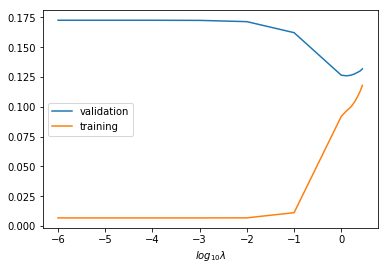

In [213]:
# 3.1.3 plot of training and validation loss as a function of \lambda

plt.plot(np.log10(lambda_vec),score_mat[:,1],label = 'validation')
plt.plot(np.log10(lambda_vec),score_mat[:,2],label = 'training')
plt.xlabel('$log_{10} \lambda$')
plt.legend()
plt.show()

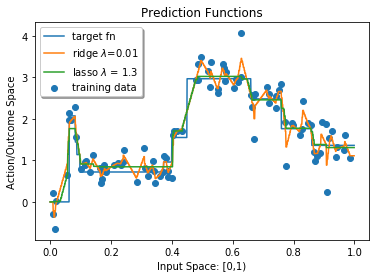

In [229]:
# 3.1.3 prediction function plot 
# fig 3_1_3b

pred_fns = []
xx = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
XX = featurize(xx)

# target function
pred_fns.append({"name":"target fn", "coefs":coefs_true, "preds": target_fn(xx) })

# best fit ridge function
l2reg = .01
ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
ridge_regression_estimator.fit(X_train, y_train)
name = "ridge $\lambda$="+str(l2reg)
pred_fns.append({"name":name,
                 "coefs":ridge_regression_estimator.w_,
                 "preds": ridge_regression_estimator.predict(XX[:,0:-5])})

# best fit lasso function
lambdaa = 1.3
ww,_,_ = shooting_algorithm(X_train,y_train,lambdaa, w = 'ridge')

pred_fns.append({"name":'lasso $\lambda$ = 1.3',
                     "coefs": ww,
                     "preds": np.dot(XX[:,0:-5],ww)})

f = plot_prediction_functions(xx, pred_fns, x_train, y_train, legend_loc="best")
f.show()

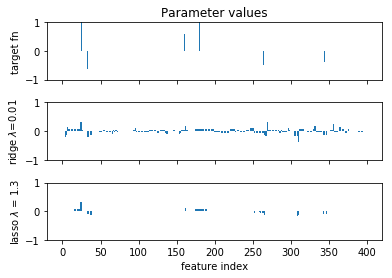

In [230]:
# 3.1.3 coefficient plot
f = plot_parameter_vectors(pred_fns)
f.show()

In [233]:
395 - 315

80

In [ ]:
# 3.1.3 coefficient histogram

# FROM RIDGE
minn = -2
maxx = 2
binwidth = .01
fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
num_ftrs = len(pred_fns[0]["coefs"])
for i in range(len(pred_fns)):
    if i == 0:
        title = 'Histogram of coefficient values'
    else:
        title = ' '
    
    coef_vals = pred_fns[i]["coefs"]
    axs[i].hist(coef_vals,bins=np.arange(minn, maxx + binwidth, binwidth))
    axs[i].set_title(title)

    if (i == (len(pred_fns)-1)): 
        axs[i].set_xlabel('coefficient value')
    else:
        axs[i].set_xlabel(' ')
        
    axs[i].set_xlim([minn,maxx])
    #axs[i].set_ylim([0, 50])

fig.subplots_adjust(hspace=0.4)
fig.show()

In [ ]:
#l2regs = [0, .01]
X = featurize(xx)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "$\lambda$="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

In [208]:
lambda_vec

array([1.0e-06, 1.0e-05, 1.0e-04, 1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00,
       1.3e+00, 1.6e+00, 1.9e+00, 2.2e+00, 2.5e+00, 2.8e+00])

In [236]:
# 3.1.4 homotopy method

n_features = X_train.shape[1]

lambda_max = 2*max(abs(np.dot(np.transpose(X_train),y_train)))
ww = np.dot(np.linalg.inv(np.dot(np.transpose(X_train),X_train) + lambda_max*np.identity(n_features)), np.dot(np.transpose(X_train),y_train))

w_hat_mat = .1* np.ones(n_features)
t_loss_vec = []
v_loss_vec = []
lambda_vec = []
n_iter_vec = []
for i_lambda in range(29):

    lambdaa = lambda_max * 0.8**i_lambda
    ww,loss,i_iter = shooting_algorithm(X_train,y_train,lambdaa, w = ww)
    
    w_hat_mat = np.vstack((w_hat_mat, ww))
    t_loss_vec = np.append(t_loss_vec, loss)
    v_loss_vec = np.append(v_loss_vec,calc_loss(X_val,y_val,ww))
    lambda_vec = np.append(lambda_vec,lambdaa)
    n_iter_vec = np.append(n_iter_vec,i_iter)
    


/Applications/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/Applications/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


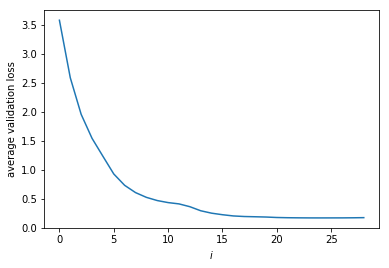

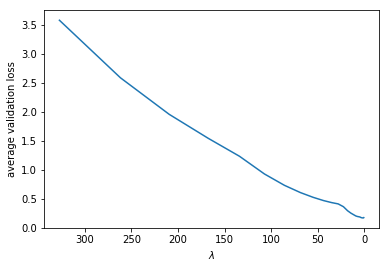

In [241]:
# 3.1.4 plotting average validation loss as a function of lambda

plt.plot(range(29),v_loss_vec)
plt.xlabel('$i$')
plt.ylabel('average validation loss')
plt.show()

plt.plot(lambda_vec,v_loss_vec)
plt.xlabel('$\lambda$')
plt.ylabel('average validation loss')
ax = plt.gca()
ax.invert_xaxis()
plt.show()
    

In [234]:
v_loss_vec[-1]

0.17192407349837693

In [103]:
# XXX cont see loss as a function of random lambdas

# shuffle lambda
lambdaa_vec = np.arange(2*max(abs(np.dot(np.transpose(X_train),y_train))),0,-5)
shuffle(lambdaa_vec)
print(lambdaa_vec)




[ 97.28283233 302.28283233  12.28283233 282.28283233  82.28283233
 202.28283233 297.28283233 207.28283233 182.28283233 127.28283233
  42.28283233 242.28283233 162.28283233 177.28283233 102.28283233
  52.28283233 217.28283233 252.28283233  57.28283233 122.28283233
 272.28283233   7.28283233  72.28283233 132.28283233 222.28283233
 312.28283233 112.28283233 267.28283233 167.28283233  77.28283233
 152.28283233 277.28283233  92.28283233 197.28283233 292.28283233
  17.28283233  87.28283233 212.28283233  32.28283233   2.28283233
 157.28283233 117.28283233  27.28283233  22.28283233 172.28283233
 232.28283233 227.28283233 257.28283233 142.28283233 317.28283233
 237.28283233 287.28283233 147.28283233 262.28283233 307.28283233
 322.28283233 247.28283233 187.28283233  47.28283233  62.28283233
 192.28283233 327.28283233 107.28283233 137.28283233  67.28283233
  37.28283233]


In [42]:
blah = []
blah = np.append(blah,[[.22],[3]])
print(blah)

[0.22 3.  ]
